## Objectively Identifying Basin Masks on a 1x1-degree Grid Using Ice-9

The `genBasinMasks()` function in m6toolbox objectively identifies basin masks based on strategically placed seed locations and a flood-filling algorithm (Ice-9).  The function was used to identify basin masks on the 0.25-degree and 0.5-degree tripolar grids in OM4 development.

In order to facilitate more ocean model ouptput analysis, the community is increasing the amount of output regridded to a spherical 1x1 degree grid that is consistent with other observation products (e.g. World Ocean Atlas, GLODAP gridded climatology).  When native model data is regridded, partial ocean cells are introduced and traditional boundaries for connectivity are lost.  This leads to a breakdown of the flood filling approach used by `genBasinMasks()`

Observational products on the 1x1 degree grid provide basin masks but their overall land-sea masks do not agree with each other or with the model's regridded land-sea mask.  It is desireable to have the capability to compute a basin-mask objectively and independently.

The overall approach is as follows:

* Diagnose the wet mask for the regridded 1x1 output that includes partial ocean cells
* Apply the World Ocean Atlas land sea mask as a first guess for connectivity
* Apply a nearest-neighbor alogorithm to fill in unassigned points and partial ocean cells

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import om4labs
import matplotlib.pyplot as plt

In [2]:
# Reload m6toolbox quickly (for testing during development)
import imp
imp.reload(om4labs.m6toolbox)

<module 'om4labs.m6toolbox' from '/Users/krasting/pkgs/om4labs/om4labs/m6toolbox.py'>

### Reading 1x1 Static File

In [48]:
# Open the 1x1 static file that includes lat, lon, deptho
ds = xr.open_dataset('/Users/krasting/pkgs/om4labs/testing/test_data/model_grids/OM4p125/ocean_1x1deg.static.nc')

In [49]:
# load x and y coordinates
x,y = np.meshgrid(ds.lon.values,ds.lat.values)

# load deptho, fill missing values with zeros
depth = ds.deptho.fillna(0.0).values

### World Ocean Atlas Land Sea Mask

The `m6toolbox.generate_woamask()` reads an optional CSV file following World Ocean Atlas conventions and returns an array of ones and zeros for the land sea mask.  The default is to use WOA13 locations and the CSV file is packaged with om4labs for convienence.

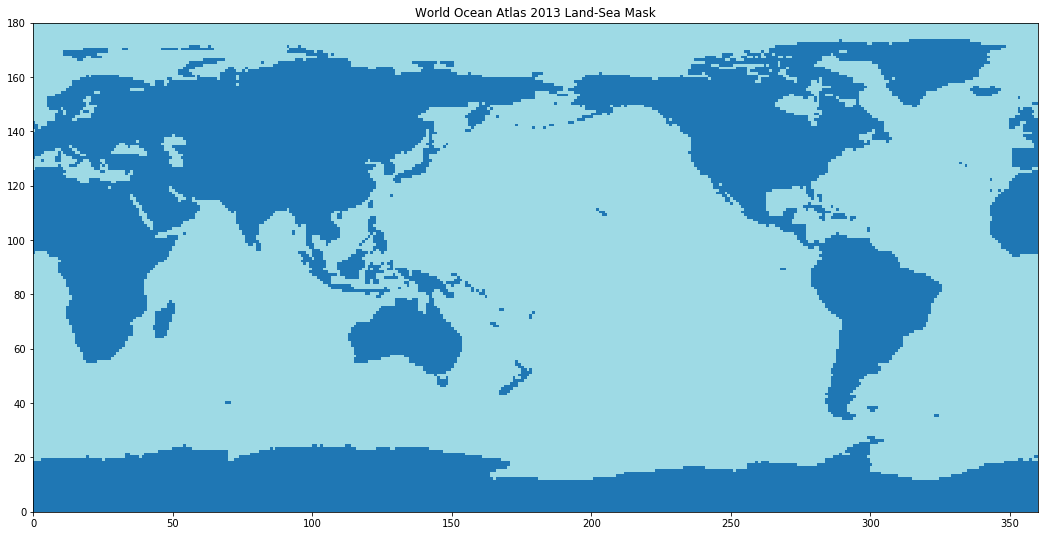

In [50]:
ext_mask = om4labs.m6toolbox.generate_woamask()

plt.figure(figsize=(18,9))
plt.pcolormesh(ext_mask,cmap='tab20')
plt.title("World Ocean Atlas 2013 Land-Sea Mask")

### Running genBasinMasks

In [51]:
# genBasinMasks() assumes lon values range from -300 to 60
x = np.roll(x,-60,axis=-1)
x = np.where(x > 60, x-360, x)
depth = np.roll(depth,-60,axis=-1)
ext_mask = np.roll(ext_mask,-60,axis=-1)

The output of `genBasinMasks` is extended here for illustrative purposes and for development.

* `code`: 2-d array of basin codes
* `tmp`: internal array used by the function for masking basins
* `wet`: the model's original wet mask including partial cells

In [76]:
code, tmp, wet = om4labs.m6toolbox.genBasinMasks(x,y,depth,verbose=True,tripolar=False,external_mask=ext_mask)

Generating global wet mask ...
done.
Finding Cape of Good Hope ...
done. -34.5
Finding Melbourne ...
done. -39.5
Processing Persian Gulf ...
Processing Red Sea ...
Processing Black Sea ...
Processing Mediterranean ...
Processing Baltic ...
Processing Hudson Bay ...
Processing Arctic ...
Processing Pacific ...
Processing Atlantic ...
Processing Indian ...
Processing Southern Ocean ...
There are leftover points unassigned to a basin code
-238.5 -0.5 [89, 61]
-259.5 3.5 [93, 40]
-237.5 12.5 [102, 62]
-110.5 26.5 [116, 189]
-111.5 27.5 [117, 188]
-113.50000000000003 30.5 [120, 186]
25.5 38.5 [128, 325]
24.5 39.5 [129, 324]
25.5 39.5 [129, 325]
17.5 41.5 [131, 317]
18.5 41.5 [131, 318]
15.5 42.5 [132, 315]
16.5 42.5 [132, 316]
14.500000000000002 43.5 [133, 314]
15.5 43.5 [133, 315]
13.5 44.5 [134, 313]
37.5 46.5 [136, 337]
0.5 50.5 [140, 300]
-131.5 54.5 [144, 168]
11.5 56.5 [146, 311]
11.5 57.5 [147, 311]
-196.5 58.5 [148, 103]
10.5 58.5 [148, 310]
-152.5 59.5 [149, 147]
-198.5 60.5 [150, 

### Cleaning up the 1x1 Basin Codes

The model's map of the land sea mask on the 1x1 grid (`wet`) illustrates the issue of partial cells.  If the Ice-9 algorithm were applied to this map, the basin connectivity would result in a failure to properly separate basis.  In particular, note the absence of Panama and connection between the Mediterranean and Red Seas.  The Canadian Archipelago is another problem region.

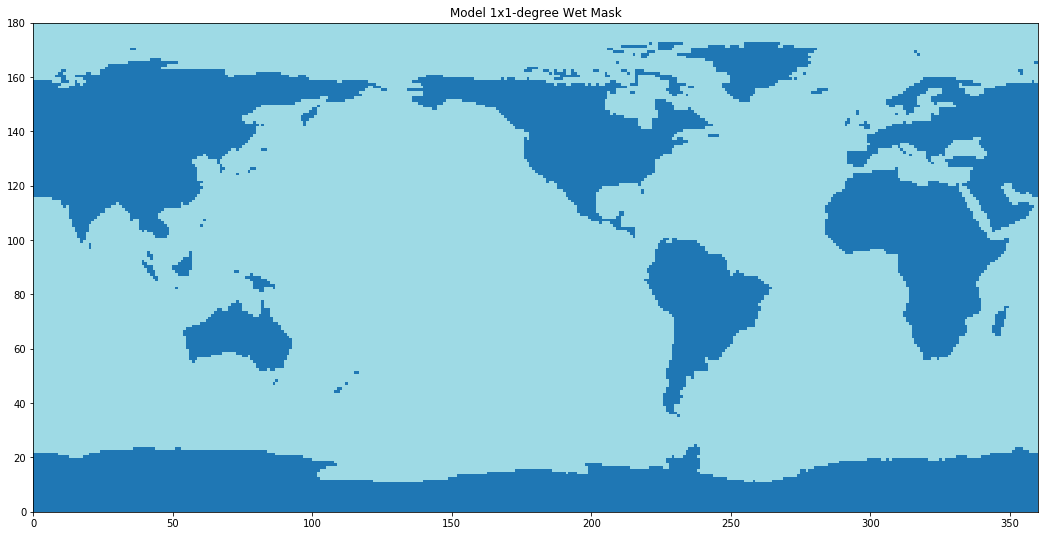

In [77]:
plt.figure(figsize=(18,9))
plt.pcolormesh(wet,cmap='tab20')
plt.title("Model 1x1-degree Wet Mask")

Applying the WOA13 mask prior to calling Ice-9 solves this issue.  The basin codes (`code`) look reasonable although there are a number of points that are unassigned (values of -9).  There are also additional model points that were masked out when the WOA13 mask was applied.

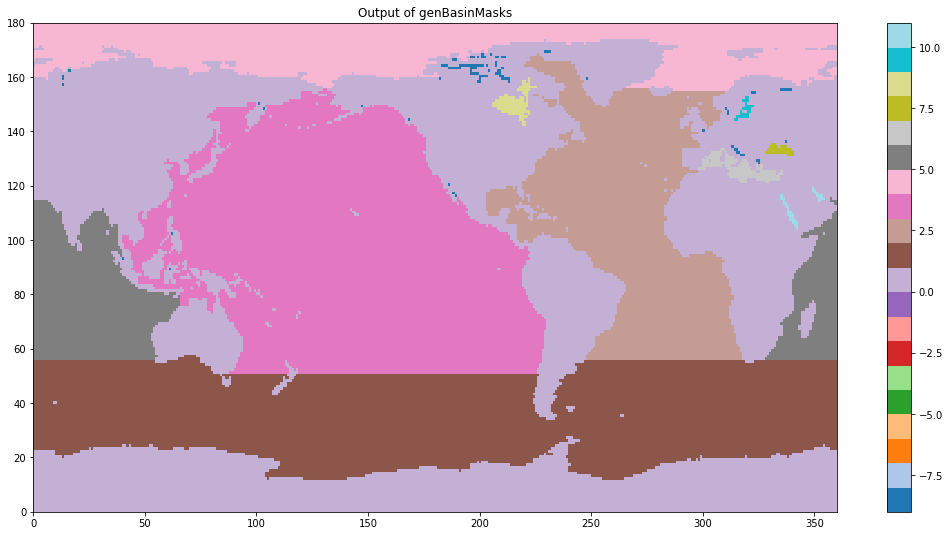

In [78]:
plt.figure(figsize=(18,9))
plt.pcolormesh(code,cmap='tab20')
plt.title("Output of genBasinMasks")
plt.colorbar()

Here, we take all land points (`code` = 0) and all unassigned point (`code` = -9) and mask them.

In [79]:
code_masked = code.copy()

# Include Canadian Archipelago in Arctic
ca_arch = np.logical_and(np.logical_and(x<-75,y>65),code==-9)
code_masked[ca_arch] = 4
code[ca_arch] = 4

# Ensure Suez Canal and South are in Red Sea
suez = np.logical_and(np.logical_and(np.logical_and(y>27,y<30),np.logical_and(x>33,x<37)),code==0)
code_masked[suez] = 10
code[suez] = 10

code_masked[code == -9] = np.nan
code_masked[code == 0] = np.nan

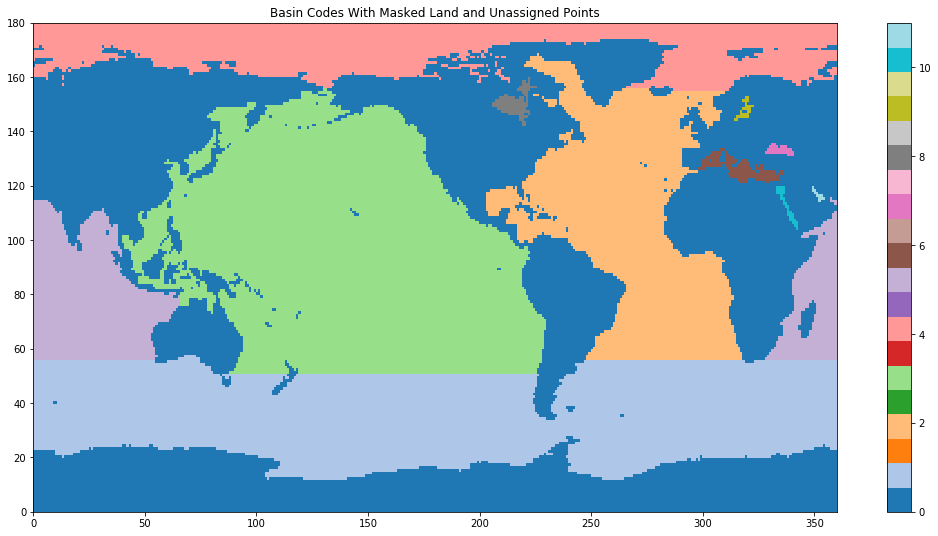

In [80]:
plt.figure(figsize=(18,9))
plt.pcolormesh(np.where(np.isnan(code_masked),0,code_masked),cmap='tab20')
plt.colorbar()
plt.title("Basin Codes With Masked Land and Unassigned Points")

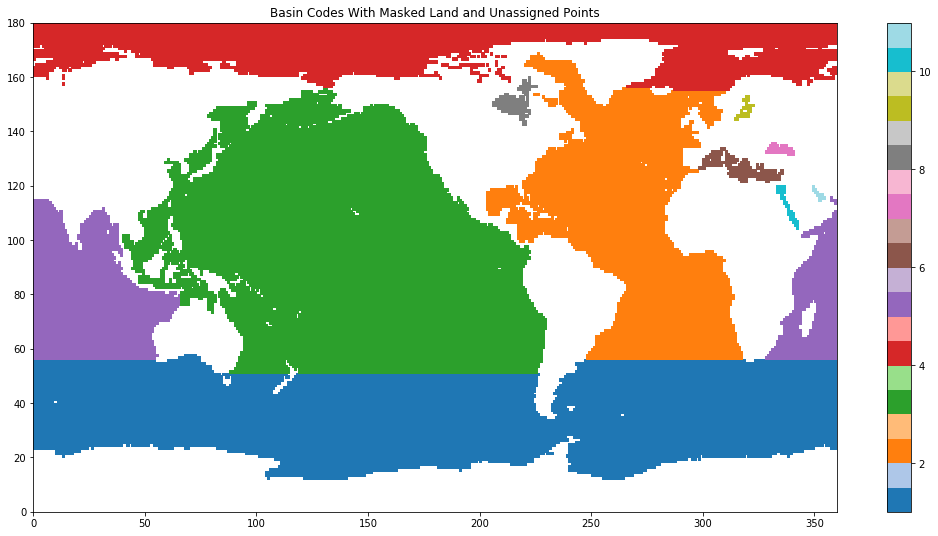

In [81]:
plt.figure(figsize=(18,9))
plt.pcolormesh(np.ma.masked_where(np.isnan(code_masked),code_masked),cmap='tab20')
plt.colorbar()
plt.title("Basin Codes With Masked Land and Unassigned Points")

Next, we use an image filling function to create a completely filled image

In [82]:
from scipy import ndimage as nd

def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. 
                 data value are replaced where invalid is True
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """    
    if invalid is None: invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, 
                                    return_distances=False, 
                                    return_indices=True)
    return data[tuple(ind)]

In [83]:
code_filled = fill(code_masked)

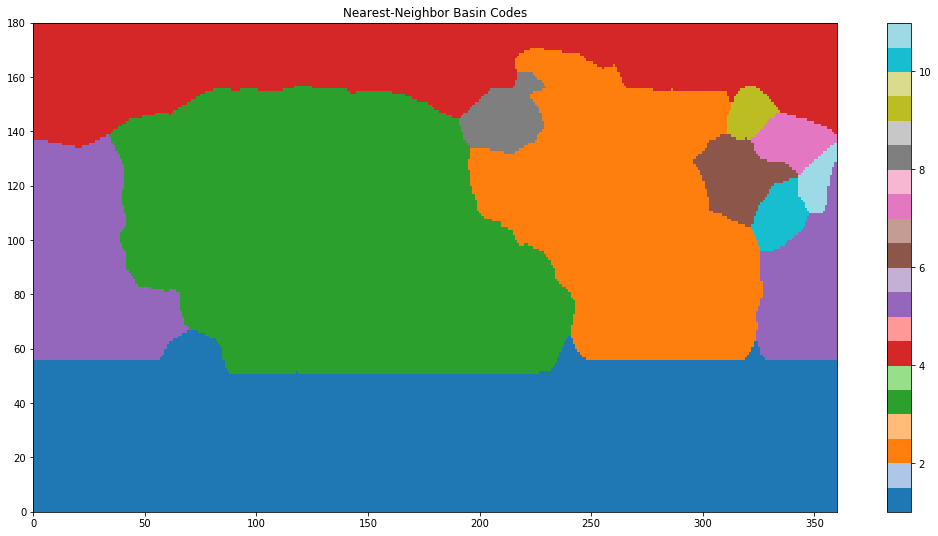

In [84]:
plt.figure(figsize=(18,9))
plt.pcolormesh(code_filled,cmap='tab20')
plt.colorbar()
plt.title("Nearest-Neighbor Basin Codes")

Finally, we reapply the model's original wet mask

In [85]:
code_final = code_filled * wet
code_final = np.roll(code_final,60,axis=-1)

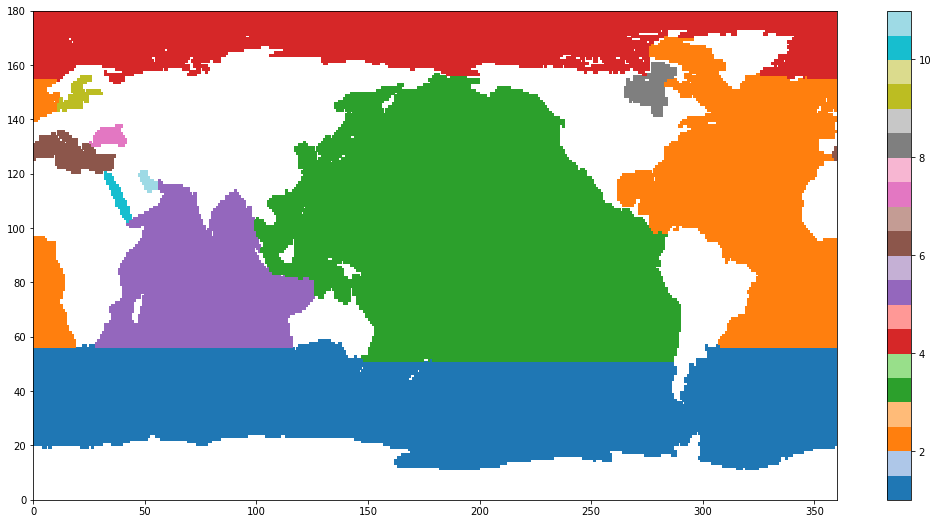

In [86]:
plt.figure(figsize=(18,9))
plt.pcolormesh(np.ma.masked_where(code_final==0,code_final),cmap='tab20')
plt.colorbar()